<a href="https://colab.research.google.com/github/doron-meizlik/FamilyMemberClassifier/blob/main/Make_Final_Model_with_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro and Prep Work

## Import packages 


In [ ]:
# import libraries

import os
import io
import datetime
from packaging import version
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from datetime import datetime
from sklearn.metrics import classification_report
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
import collections
import math

from collections import Counter
import numpy as np
import pandas as pd

# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models, layers, regularizers, preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AvgPool2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
#from keras.applications.resnet50 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
#from keras.applications.VGG16 import preprocess_input

from PIL import Image

%matplotlib inline


## Verify Versions

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
print("Keras version: ", keras.__version__)

assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.5.0
Keras version:  2.5.0


In [ ]:
# suppress warnings

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Set Seed

In [ ]:
# To get consistint results each time we rerun the code.

def reset(rs=826):
  keras.backend.clear_session()
  np.random.seed(rs)
  tf.random.set_seed(rs)
  random_seed = rs

reset(826)

## Setup for Colab

In [ ]:
# Mount Google Drive to Colab Environment

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# change working directory

os.getcwd()
%cd '/content/gdrive/My Drive/MSDS 462/Final Project Model/'
!pwd
!ls
#print('Working Directory')
#print(os.getcwd())
work_dir = "/content/gdrive/My Drive/MSDS 462/Final Project Model/"
data_dir = "/content/gdrive/My Drive/MSDS 462/Module 9/DataFolders3/"


/content/gdrive/My Drive/MSDS 462/Final Project Model
/content/gdrive/My Drive/MSDS 462/Final Project Model
'Make Final Model with Transfer Learning.ipynb'   train_processed.npy
 test_processed.npy


## Load Data

In [ ]:
DATA_LOC = data_dir
TRAIN_FRACTION = 90/114
RANDOM_SEED = 826


def make_train_and_test_sets():
  """Split the data into train and test sets and get the label classes."""
  train_examples, test_examples = [], []
  shuffler = random.Random(RANDOM_SEED)
  is_root = True
  for (dirname, subdirs, filenames) in tf.io.gfile.walk(DATA_LOC):
    # The root directory gives us the classes
    if is_root:
      subdirs = sorted(subdirs)
      classes = collections.OrderedDict(enumerate(subdirs))
      label_to_class = dict([(x, i) for i, x in enumerate(subdirs)])
      is_root = False
    # The sub directories give us the image files for training.
    else:
      filenames.sort()
      shuffler.shuffle(filenames)
      full_filenames = [os.path.join(dirname, f) for f in filenames]
      label = dirname.split('/')[-1]
      label_class = label_to_class[label]
      # An example is the image file and it's label class.
      examples = list(zip(full_filenames, [label_class] * len(filenames)))
      num_train = int(len(filenames) * TRAIN_FRACTION)
      train_examples.extend(examples[:num_train])
      test_examples.extend(examples[num_train:])

  shuffler.shuffle(train_examples)
  shuffler.shuffle(test_examples)
  return train_examples, test_examples, classes


In [ ]:
# split the images into train and test sets.
TRAIN_EXAMPLES, TEST_EXAMPLES, CLASSES = make_train_and_test_sets()
NUM_CLASSES = len(CLASSES)

print('\nThe dataset has %d label classes: %s' % (NUM_CLASSES, CLASSES.values()))
print('There are %d training images' % len(TRAIN_EXAMPLES))
print('there are %d test images' % len(TEST_EXAMPLES))


The dataset has 6 label classes: odict_values(['Abby', 'Doron', 'Lily', 'Paige', 'Toby', 'Zoey'])
There are 540 training images
there are 144 test images


### Display Sample Images

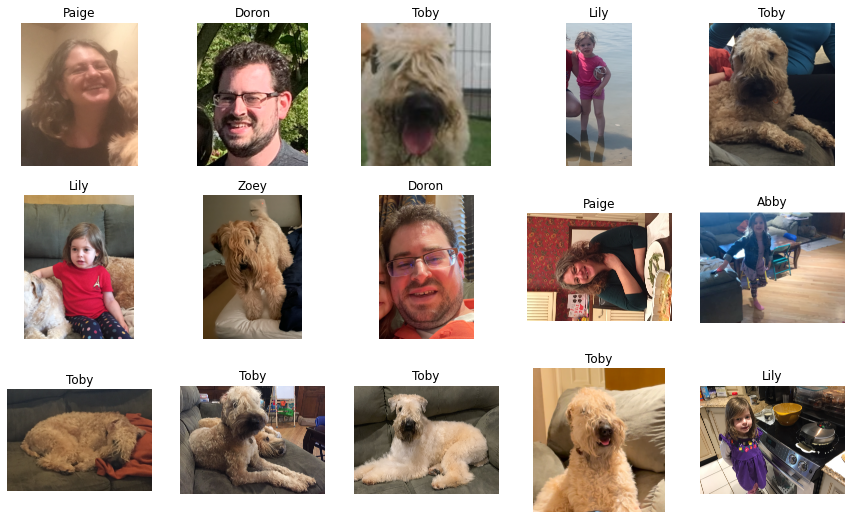

In [ ]:
# show sample images

NUM_IMAGES = 15


def get_label(example):
  """Get the label (number) for given example."""
  return example[1]

def get_class(example):
  """Get the class (string) of given example."""
  return CLASSES[get_label(example)]

def get_encoded_image(example):
  """Get the image data (encoded jpg) of given example."""
  image_path = example[0]
  return tf.io.gfile.GFile(image_path, 'rb').read()

def get_image(example):
  """Get image as np.array of pixels for given example."""
  return plt.imread(io.BytesIO(get_encoded_image(example)), format='jpg')

def display_images(images_and_classes, cols=5):
  """Display given images and their labels in a grid."""
  rows = int(math.ceil(len(images_and_classes) / cols))
  fig = plt.figure()
  fig.set_size_inches(cols * 3, rows * 3)
  for i, (image, person_class) in enumerate(images_and_classes):
    plt.subplot(rows, cols, i + 1)
    plt.axis('off')
    plt.imshow(image)
    plt.title(person_class)

display_images([(get_image(example), get_class(example))
               for example in TRAIN_EXAMPLES[:NUM_IMAGES]])

### Pre-Process Training Images

In [ ]:
# read in 64x64 color data

train_processed = np.load(work_dir+'train_processed.npy')
test_processed = np.load(work_dir+'test_processed.npy')

In [ ]:
#train_processed = [None] * len(TRAIN_EXAMPLES)

#for n in range(len(TRAIN_EXAMPLES)):
#  #img = Image.open(TRAIN_EXAMPLES[0][0])
#  img = image.load_img(TRAIN_EXAMPLES[n][0], target_size=(300, 300))
#  img = image.img_to_array(img) / 255
#  train_processed[n] = img


In [ ]:
# pre-process all training 546 training images (turn all into 300x300 3d numpy arrays)

#train_processed = [None] * len(TRAIN_EXAMPLES)

#for n in range(len(TRAIN_EXAMPLES)):
#  byteImgIO = io.BytesIO()
#  byteImg = Image.open(TRAIN_EXAMPLES[n][0])
#  byteImg.save(byteImgIO, "PNG")
#  byteImgIO.seek(0)
#  byteImg = byteImgIO.read()
#  dataBytesIO = io.BytesIO(byteImg)
#  img = Image.open(dataBytesIO)
#  img = image.img_to_array(img)/255
#  img = img[...,:3]
#  img = image.smart_resize(img, (299,299), interpolation='bilinear')
#  train_processed[n] = img

#train_processed = np.array(train_processed)
#train_processed.shape


In [ ]:
# save off npy file with numpy arrays for all 546 training images

#np.save(os.path.join(work_dir, 'train_processed.npy'), train_processed)


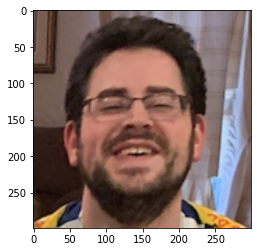

In [ ]:
# show image for last of the training arrays
plt.imshow(train_processed[539])

### Pre-Process Testing Images

In [ ]:
# pre-process all training 138 training images (turn all into 300x300 3d numpy arrays)

#test_processed = [None] * len(TEST_EXAMPLES)

#for n in range(len(TEST_EXAMPLES)):
#  byteImgIO = io.BytesIO()
#  byteImg = Image.open(TEST_EXAMPLES[n][0])
#  byteImg.save(byteImgIO, "PNG")
#  byteImgIO.seek(0)
#  byteImg = byteImgIO.read()
#  dataBytesIO = io.BytesIO(byteImg)
#  img = Image.open(dataBytesIO)
#  img = image.img_to_array(img)/255
#  img = img[...,:3]
#  img = image.smart_resize(img, (299,299), interpolation='bilinear')
#  test_processed[n] = img

#test_processed = np.array(test_processed)
#test_processed.shape


In [ ]:
# save off npy file with numpy arrays for all 138 testing images
#np.save(os.path.join(work_dir, 'test_processed.npy'), test_processed)

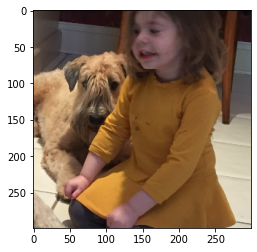

In [ ]:
# show image for last of the testing arrays
plt.imshow(test_processed[143])

### Pre-Process Labels

In [ ]:
# make labels for training set

y_train = [None] * len(TRAIN_EXAMPLES)

for n in range(len(TRAIN_EXAMPLES)):
  y_train[n] = TRAIN_EXAMPLES[n][1]

y_train = np.array(y_train)
y_train.shape


(540,)

In [ ]:
# make labels for test set

y_test = [None] * len(TEST_EXAMPLES)

for n in range(len(TEST_EXAMPLES)):
  y_test[n] = TEST_EXAMPLES[n][1]

y_test = np.array(y_test)
y_test.shape


(144,)

In [ ]:
# print shape of all train/test samples

print('train_images:\t{}'.format(train_processed.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(test_processed.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(540, 299, 299, 3)
train_labels:	(540,)
test_images:		(144, 299, 299, 3)
test_labels:		(144,)


# EDA


### Review labels for training dataset

In [ ]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))


First ten labels training dataset:
 [3 1 4 2 4 2 5 1 3 0]



### Find frequency of each label in the training and test data

In [ ]:
# from collections import Counter
Counter(y_train).most_common()

[(3, 90), (1, 90), (4, 90), (2, 90), (5, 90), (0, 90)]

In [ ]:
Counter(y_test).most_common()

[(5, 24), (0, 24), (1, 24), (3, 24), (4, 24), (2, 24)]

In [ ]:
# show one array (show it's already normalized)
train_processed[0]

array([[[0.65292805, 0.54312414, 0.41763395],
        [0.65589535, 0.54609144, 0.42060122],
        [0.6598435 , 0.5500396 , 0.42454937],
        ...,
        [0.972549  , 0.85490197, 0.7137255 ],
        [0.9715947 , 0.85394764, 0.7127712 ],
        [0.9696209 , 0.85197383, 0.71079737]],

       [[0.6588889 , 0.54809153, 0.42260137],
        [0.654902  , 0.54509807, 0.41960785],
        [0.6598164 , 0.55001247, 0.42555577],
        ...,
        [0.9706536 , 0.85300654, 0.7118301 ],
        [0.96862745, 0.8509804 , 0.70980394],
        [0.96862745, 0.8509804 , 0.70980394]],

       [[0.67345095, 0.56270576, 0.43721557],
        [0.65699524, 0.5471913 , 0.4217011 ],
        [0.65790766, 0.54810375, 0.42561916],
        ...,
        [0.9706536 , 0.85300654, 0.7118301 ],
        [0.9667059 , 0.84905887, 0.7078824 ],
        [0.9647059 , 0.84705883, 0.7058824 ]],

       ...,

       [[0.2893205 , 0.23441851, 0.19520283],
        [0.29138616, 0.23648418, 0.19537307],
        [0.28346282, 0

### Plot Examples

In [ ]:
class_names = ['Abby','Doron', 'Lily', 'Paige', 'Toby', 'Zoey']

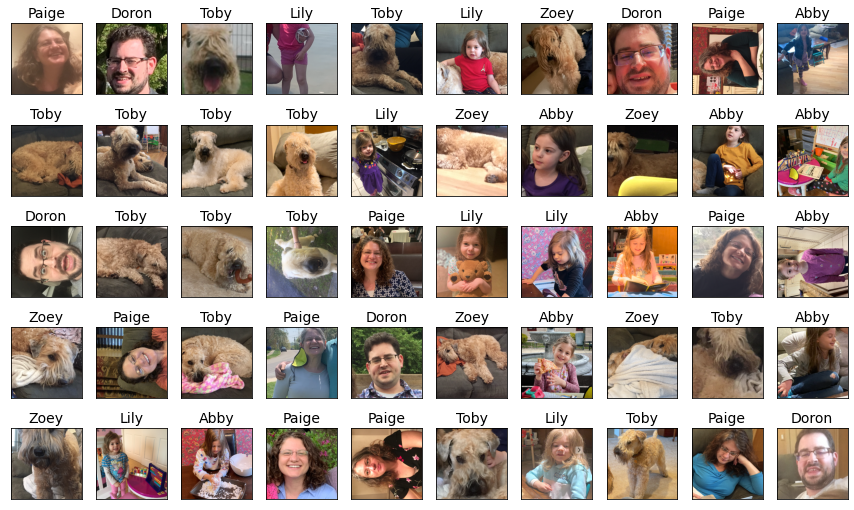

In [ ]:
fig = plt.figure(figsize = (15, 9))

for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.title(class_names[y_train[i]], fontsize=14)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_processed[i])

# Prepare for Modeling

## Prepare Data

In [ ]:
# define random seed
rs = 826

X_traintest = train_processed
y_traintest = y_train

X_validate = test_processed
y_validate = y_test

# set aside 5000 for training
random_seed = rs
X_train, X_test, y_train, y_test = train_test_split(X_traintest, y_traintest,
      test_size = 100/540, shuffle = True, random_state = random_seed, stratify=y_traintest)

print("Shape of X_traintest:", X_traintest.shape)
print("Shape of y_traintest:", y_traintest.shape)
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of X_validate:", X_validate.shape)
print("Shape of y_validate", y_validate.shape)

Shape of X_traintest: (540, 299, 299, 3)
Shape of y_traintest: (540,)
Shape of X_train: (440, 299, 299, 3)
Shape of y_train: (440,)
Shape of X_test: (100, 299, 299, 3)
Shape of y_test: (100,)
Shape of X_validate: (144, 299, 299, 3)
Shape of y_validate (144,)


## Build Function for Models

In [ ]:
def build_model(k, model, batchsize, X_train, y_train, X_test, y_test, X_validate, y_validate):

  # reset 
  reset(rs)
  batch = batchsize

  # start clock
  start=datetime.now()

  # build model structure 
  model = model

  # compile the model
  model.compile(
      optimizer=tf.keras.optimizers.RMSprop(),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
  )

  # define callbacks
  early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience = 18, restore_best_weights = True)

  # fit the model
  history = model.fit(
    X_train, y_train,
    epochs = 500,
    validation_data = (X_test, y_test),
    callbacks = [early_stopping_cb],
    batch_size = batch
  )

  # stop clock and calc runtime
  end=datetime.now()
  time_elapsed = round((end-start).total_seconds(), 1)

  # save off model predictions
  test_prob = model.predict_proba(X_test)
  test_pred = model.predict_classes(X_test)
  validate_prob = model.predict_proba(X_validate)
  validate_pred = model.predict_classes(X_validate)

  # save final model accuracy measures
  train_loss = round(model.evaluate(X_train, y_train)[0], 4)
  train_accuracy = round(model.evaluate(X_train, y_train)[1], 4)
  test_loss = round(model.evaluate(X_test, y_test)[0], 4)
  test_accuracy = round(model.evaluate(X_test, y_test)[1], 4)
  validate_loss = round(model.evaluate(X_validate, y_validate)[0], 4)
  validate_accuracy = round(model.evaluate(X_validate, y_validate)[1], 4)

  # create plot of performance metrics
  history_dict = history.history
  history_dict.keys()
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)
  plt.figure(figsize=(12, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

  # save model name
  name = f"Model {k}"

  # create output
  output = {'name': name, 'time_elapsed': time_elapsed, 'train_accuracy': train_accuracy, 'test_accuracy': test_accuracy, 'validate_accuracy': validate_accuracy, 'train_loss': train_loss, 'test_loss': test_loss, 'validate_loss': validate_loss, 'test_prob': test_prob, 'test_pred': test_pred, 'validate_prob': validate_prob, 'validate_pred': validate_pred}
  return output


In [ ]:
def model_eval(model_output):

  NN = model_output

  # save variables to use in model evaluation
  name = NN['name']
  time_elapsed = NN['time_elapsed']
  train_loss = NN['train_loss']
  train_accuracy = NN['train_accuracy']
  test_loss = NN['test_loss']
  test_accuracy = NN['test_accuracy']
  validate_loss = NN['validate_loss']
  validate_accuracy = NN['validate_accuracy']
  test_pred = NN['test_pred']
  test_prob = NN['test_prob']
  validate_pred = NN['validate_pred']
  validate_prob = NN['validate_prob']

  # print off accuracy report
  print('\n', name, '\n\n')
  print('Time Elapsed:', time_elapsed, ' seconds', '\n')
  print('Validation Accuracy:', validate_accuracy, '\n')
  print('Validation Classification Report:')
  print(classification_report(validate_pred, y_validate, digits = 4))
  confmat = confusion_matrix(y_validate, validate_pred)
  fig = plt.figure(figsize=(7,7))
  confmat_plt = sns.heatmap(confmat.T, square=True, annot=True, fmt='d', cbar=False, cmap="Blues")
  plt.xlabel('Actual Label')
  plt.ylabel('Predicted Label')
  plt.title("Validation Set Confusion Matrix\n");
  fig = confmat_plt.get_figure()
  fig.show()
  #print('\n',
  #'0- Abby', '\n',
  #'1- Doron', '\n',
  #'2- Lily', '\n',
  #'3- Paige', '\n',
  #'4- Toby', '\n',
  #'5- Zoey', '\n')


# Build Transfer Learning Model

### Extract Features

In [ ]:
feature_extractor_layer = hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/classification/5", input_shape=(299, 299, 3), trainable=False)

## Build Two Experimental Model Architecture

In [ ]:
# model architecture 1

dropout_rate = 0.2 # just for purposes of displaying summary, will be a variable later

model1 = tf.keras.Sequential([
  feature_extractor_layer,
  keras.layers.Dense(360, activation='relu'),
  keras.layers.Dropout(dropout_rate),
  keras.layers.Dense(6, activation='softmax')
])

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              23853833  
_________________________________________________________________
dense (Dense)                (None, 360)               360720    
_________________________________________________________________
dropout (Dropout)            (None, 360)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 2166      
Total params: 24,216,719
Trainable params: 362,886
Non-trainable params: 23,853,833
_________________________________________________________________


In [ ]:
# model architecture 2

model2 = tf.keras.Sequential([
  feature_extractor_layer,
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dropout(dropout_rate),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dropout(dropout_rate),
  keras.layers.Dense(6, activation='softmax')
])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              23853833  
_________________________________________________________________
dense_2 (Dense)              (None, 512)               513024    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
Total params: 24,433,295
Trainable params: 579,462
Non-trainable params: 23,853,833
____________________________________

# Run Model Experiments

### Model 1

Epoch 1/500
440/440 [==============================] - 13s 15ms/step - loss: 1.6770 - accuracy: 0.6091 - val_loss: 1.5650 - val_accuracy: 0.7000
Epoch 2/500
440/440 [==============================] - 6s 13ms/step - loss: 0.6490 - accuracy: 0.8250 - val_loss: 1.6583 - val_accuracy: 0.7400
Epoch 3/500
440/440 [==============================] - 6s 13ms/step - loss: 0.3507 - accuracy: 0.9136 - val_loss: 2.3020 - val_accuracy: 0.7000
Epoch 4/500
440/440 [==============================] - 6s 13ms/step - loss: 0.2190 - accuracy: 0.9386 - val_loss: 2.4027 - val_accuracy: 0.7400
Epoch 5/500
440/440 [==============================] - 6s 13ms/step - loss: 0.0826 - accuracy: 0.9750 - val_loss: 1.9627 - val_accuracy: 0.7700
Epoch 6/500
440/440 [==============================] - 6s 14ms/step - loss: 0.0778 - accuracy: 0.9818 - val_loss: 2.3879 - val_accuracy: 0.7200
Epoch 7/500
440/440 [==============================] - 6s 13ms/step - loss: 0.0771 - accuracy: 0.9750 - val_loss: 2.3829 - val_accuracy

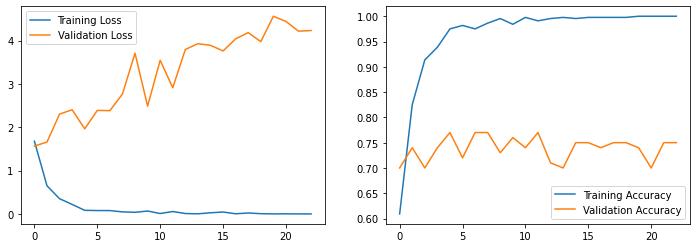

In [ ]:
# RUN MODEL 1

# inputs
k = '1'             # k is the model number
model = model1     # model architectures from above
dropout_rate = 0.2
batchsize = 1

Model_1 = build_model(k, model, batchsize, X_train, y_train, X_test, y_test, X_validate, y_validate)



 Model 1 


Time Elapsed: 141.1  seconds 

Validation Accuracy: 0.75 

Validation Classification Report:
              precision    recall  f1-score   support

           0     0.8333    0.5714    0.6780        35
           1     0.9167    0.9167    0.9167        24
           2     0.4167    0.7143    0.5263        14
           3     0.7917    0.9048    0.8444        21
           4     0.8333    0.7407    0.7843        27
           5     0.7083    0.7391    0.7234        23

    accuracy                         0.7500       144
   macro avg     0.7500    0.7645    0.7455       144
weighted avg     0.7807    0.7500    0.7545       144



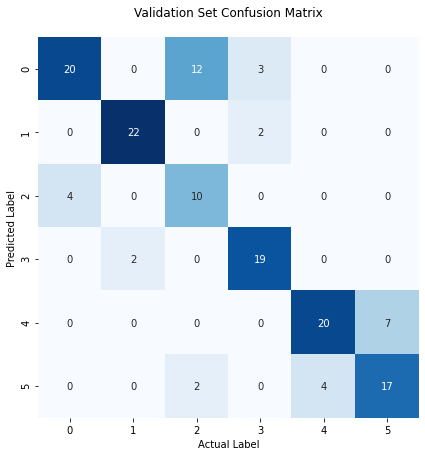

In [ ]:
model_eval(Model_1)

### Model 2

Epoch 1/500
55/55 [==============================] - 5s 39ms/step - loss: 0.0435 - accuracy: 0.9932 - val_loss: 1.9250 - val_accuracy: 0.7500
Epoch 2/500
55/55 [==============================] - 1s 27ms/step - loss: 0.0364 - accuracy: 0.9818 - val_loss: 2.2413 - val_accuracy: 0.7200
Epoch 3/500
55/55 [==============================] - 1s 27ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 2.0189 - val_accuracy: 0.7600
Epoch 4/500
55/55 [==============================] - 1s 27ms/step - loss: 5.9761e-04 - accuracy: 1.0000 - val_loss: 2.1035 - val_accuracy: 0.7600
Epoch 5/500
55/55 [==============================] - 1s 27ms/step - loss: 0.0292 - accuracy: 0.9909 - val_loss: 2.3755 - val_accuracy: 0.7400
Epoch 6/500
55/55 [==============================] - 1s 27ms/step - loss: 4.5777e-04 - accuracy: 1.0000 - val_loss: 2.2463 - val_accuracy: 0.7400
Epoch 7/500
55/55 [==============================] - 1s 27ms/step - loss: 0.0081 - accuracy: 0.9955 - val_loss: 2.5123 - val_accuracy: 0.770

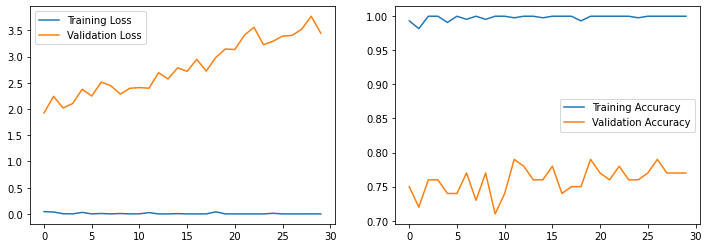

In [ ]:
# RUN MODEL 2

# inputs
k = '2'             # k is the model number
model = model1     # model architectures from above
dropout_rate = 0.2
batchsize = 8

Model_2 = build_model(k, model, batchsize, X_train, y_train, X_test, y_test, X_validate, y_validate)



 Model 2 


Time Elapsed: 48.6  seconds 

Validation Accuracy: 0.75 

Validation Classification Report:
              precision    recall  f1-score   support

           0     0.6250    0.6000    0.6122        25
           1     0.8750    0.9130    0.8936        23
           2     0.6250    0.7895    0.6977        19
           3     0.7917    0.7037    0.7451        27
           4     0.8750    0.7500    0.8077        28
           5     0.7083    0.7727    0.7391        22

    accuracy                         0.7500       144
   macro avg     0.7500    0.7548    0.7492       144
weighted avg     0.7575    0.7500    0.7508       144



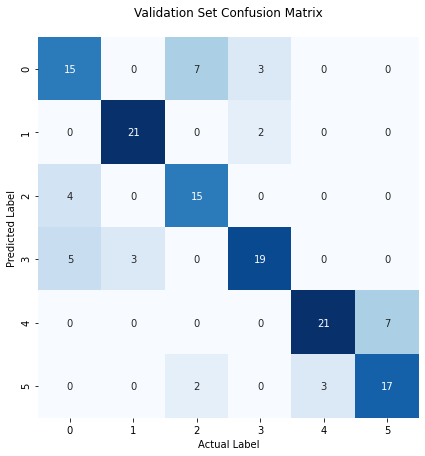

In [ ]:
model_eval(Model_2)

### Model 3

Epoch 1/500
440/440 [==============================] - 9s 15ms/step - loss: 0.0064 - accuracy: 0.9932 - val_loss: 2.5068 - val_accuracy: 0.8000
Epoch 2/500
440/440 [==============================] - 6s 13ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 3.3291 - val_accuracy: 0.7300
Epoch 3/500
440/440 [==============================] - 6s 13ms/step - loss: 9.8254e-04 - accuracy: 1.0000 - val_loss: 2.9087 - val_accuracy: 0.7700
Epoch 4/500
440/440 [==============================] - 6s 13ms/step - loss: 2.2356e-04 - accuracy: 1.0000 - val_loss: 3.1611 - val_accuracy: 0.7500
Epoch 5/500
440/440 [==============================] - 6s 13ms/step - loss: 0.0042 - accuracy: 0.9977 - val_loss: 3.6574 - val_accuracy: 0.7400
Epoch 6/500
440/440 [==============================] - 6s 13ms/step - loss: 0.0095 - accuracy: 0.9955 - val_loss: 3.9519 - val_accuracy: 0.7600
Epoch 7/500
440/440 [==============================] - 6s 13ms/step - loss: 0.0036 - accuracy: 0.9977 - val_loss: 3.6167 - val_a

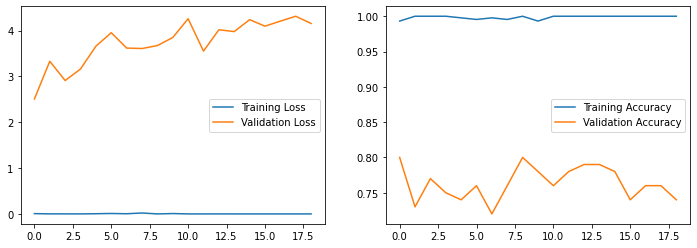

In [ ]:
# RUN MODEL 3

# inputs
k = '3'             # k is the model number
model = model1     # model architectures from above
dropout_rate = 0.4
batchsize = 1

Model_3 = build_model(k, model, batchsize, X_train, y_train, X_test, y_test, X_validate, y_validate)



 Model 3 


Time Elapsed: 114.8  seconds 

Validation Accuracy: 0.75 

Validation Classification Report:
              precision    recall  f1-score   support

           0     0.7083    0.5312    0.6071        32
           1     0.9167    0.8800    0.8980        25
           2     0.5833    0.7000    0.6364        20
           3     0.6667    0.8421    0.7442        19
           4     0.8750    0.8400    0.8571        25
           5     0.7500    0.7826    0.7660        23

    accuracy                         0.7500       144
   macro avg     0.7500    0.7627    0.7515       144
weighted avg     0.7572    0.7500    0.7485       144



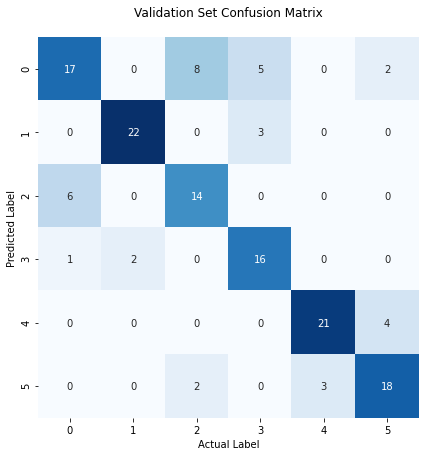

In [ ]:
model_eval(Model_3)

### Model 4

Epoch 1/500
55/55 [==============================] - 4s 39ms/step - loss: 0.0111 - accuracy: 0.9955 - val_loss: 2.8054 - val_accuracy: 0.7800
Epoch 2/500
55/55 [==============================] - 1s 27ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 2.7987 - val_accuracy: 0.7600
Epoch 3/500
55/55 [==============================] - 1s 27ms/step - loss: 2.9194e-05 - accuracy: 1.0000 - val_loss: 2.7666 - val_accuracy: 0.7500
Epoch 4/500
55/55 [==============================] - 1s 27ms/step - loss: 7.7803e-05 - accuracy: 1.0000 - val_loss: 2.9529 - val_accuracy: 0.7700
Epoch 5/500
55/55 [==============================] - 1s 27ms/step - loss: 7.5728e-05 - accuracy: 1.0000 - val_loss: 3.0864 - val_accuracy: 0.7600
Epoch 6/500
55/55 [==============================] - 1s 27ms/step - loss: 6.3927e-06 - accuracy: 1.0000 - val_loss: 3.2403 - val_accuracy: 0.7600
Epoch 7/500
55/55 [==============================] - 1s 27ms/step - loss: 0.0031 - accuracy: 0.9977 - val_loss: 3.1973 - val_accurac

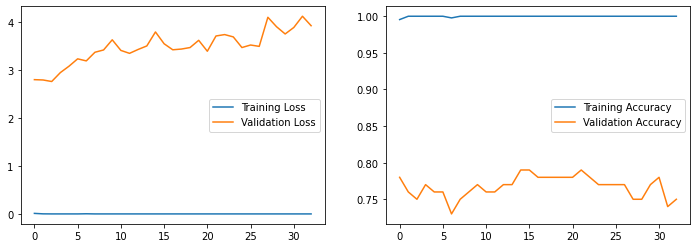

In [ ]:
# RUN MODEL 4

# inputs
k = '4'             # k is the model number
model = model1     # model architectures from above
dropout_rate = 0.4
batchsize = 8

Model_4 = build_model(k, model, batchsize, X_train, y_train, X_test, y_test, X_validate, y_validate)



 Model 4 


Time Elapsed: 51.9  seconds 

Validation Accuracy: 0.7292 

Validation Classification Report:
              precision    recall  f1-score   support

           0     0.6667    0.5333    0.5926        30
           1     0.9167    0.8462    0.8800        26
           2     0.4583    0.7333    0.5641        15
           3     0.7500    0.7826    0.7660        23
           4     0.8333    0.7692    0.8000        26
           5     0.7500    0.7500    0.7500        24

    accuracy                         0.7292       144
   macro avg     0.7292    0.7358    0.7254       144
weighted avg     0.7474    0.7292    0.7329       144



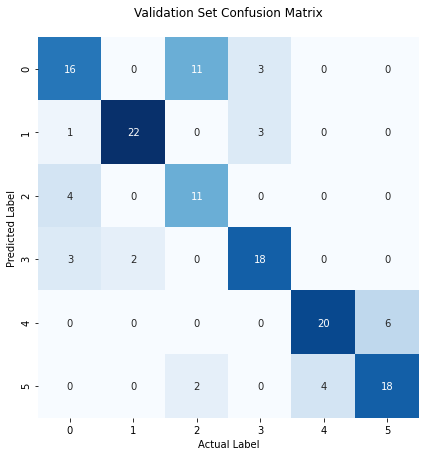

In [ ]:
model_eval(Model_4)

### Model 5

Epoch 1/500
440/440 [==============================] - 8s 15ms/step - loss: 1.5096 - accuracy: 0.5659 - val_loss: 1.7850 - val_accuracy: 0.5600
Epoch 2/500
440/440 [==============================] - 6s 13ms/step - loss: 1.0000 - accuracy: 0.7409 - val_loss: 1.8773 - val_accuracy: 0.6300
Epoch 3/500
440/440 [==============================] - 6s 14ms/step - loss: 0.6590 - accuracy: 0.8023 - val_loss: 1.8585 - val_accuracy: 0.7400
Epoch 4/500
440/440 [==============================] - 6s 13ms/step - loss: 0.4898 - accuracy: 0.8955 - val_loss: 1.5912 - val_accuracy: 0.7300
Epoch 5/500
440/440 [==============================] - 6s 14ms/step - loss: 0.3528 - accuracy: 0.9205 - val_loss: 2.2414 - val_accuracy: 0.7800
Epoch 6/500
440/440 [==============================] - 6s 13ms/step - loss: 0.3631 - accuracy: 0.9318 - val_loss: 3.0865 - val_accuracy: 0.7400
Epoch 7/500
440/440 [==============================] - 6s 13ms/step - loss: 0.2894 - accuracy: 0.9477 - val_loss: 2.8566 - val_accuracy:

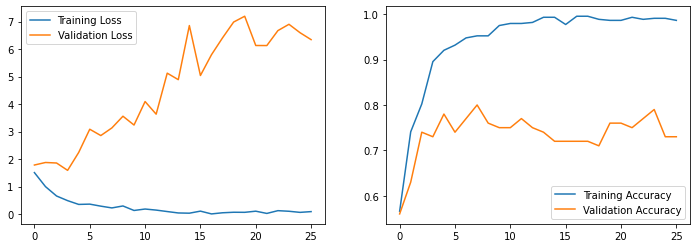

In [ ]:
# RUN MODEL 5

# inputs
k = '5'             # k is the model number
model = model2     # model architectures from above
dropout_rate = 0.2
batchsize = 1

Model_5 = build_model(k, model, batchsize, X_train, y_train, X_test, y_test, X_validate, y_validate)



 Model 5 


Time Elapsed: 158.7  seconds 

Validation Accuracy: 0.7292 

Validation Classification Report:
              precision    recall  f1-score   support

           0     0.6667    0.5000    0.5714        32
           1     0.8750    0.8400    0.8571        25
           2     0.5000    0.6000    0.5455        20
           3     0.6250    0.8824    0.7317        17
           4     0.9167    0.8148    0.8627        27
           5     0.7917    0.8261    0.8085        23

    accuracy                         0.7292       144
   macro avg     0.7292    0.7439    0.7295       144
weighted avg     0.7416    0.7292    0.7288       144



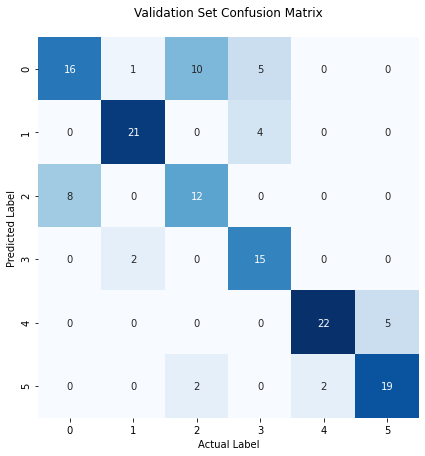

In [ ]:
model_eval(Model_5)

### Model 6

Epoch 1/500
55/55 [==============================] - 4s 40ms/step - loss: 0.1302 - accuracy: 0.9795 - val_loss: 3.6423 - val_accuracy: 0.7200
Epoch 2/500
55/55 [==============================] - 1s 27ms/step - loss: 0.1500 - accuracy: 0.9682 - val_loss: 3.6821 - val_accuracy: 0.7300
Epoch 3/500
55/55 [==============================] - 1s 26ms/step - loss: 0.0768 - accuracy: 0.9773 - val_loss: 2.7535 - val_accuracy: 0.7900
Epoch 4/500
55/55 [==============================] - 1s 27ms/step - loss: 0.0466 - accuracy: 0.9886 - val_loss: 3.0834 - val_accuracy: 0.7700
Epoch 5/500
55/55 [==============================] - 1s 27ms/step - loss: 0.0148 - accuracy: 0.9932 - val_loss: 2.6543 - val_accuracy: 0.7800
Epoch 6/500
55/55 [==============================] - 1s 27ms/step - loss: 0.0302 - accuracy: 0.9886 - val_loss: 3.4862 - val_accuracy: 0.7600
Epoch 7/500
55/55 [==============================] - 1s 27ms/step - loss: 0.0163 - accuracy: 0.9977 - val_loss: 3.5125 - val_accuracy: 0.7400
Epoch 

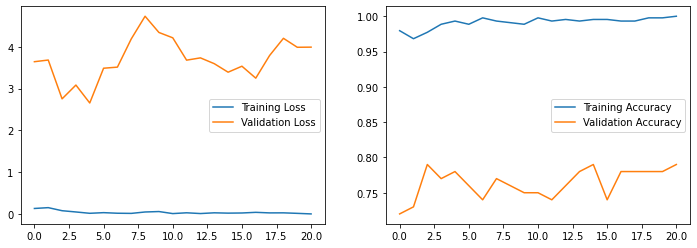

In [ ]:
# RUN MODEL 6

# inputs
k = '6'             # k is the model number
model = model2     # model architectures from above
dropout_rate = 0.2
batchsize = 8

Model_6 = build_model(k, model, batchsize, X_train, y_train, X_test, y_test, X_validate, y_validate)



 Model 6 


Time Elapsed: 34.3  seconds 

Validation Accuracy: 0.7292 

Validation Classification Report:
              precision    recall  f1-score   support

           0     0.6250    0.5357    0.5769        28
           1     0.8750    0.9130    0.8936        23
           2     0.5833    0.6667    0.6222        21
           3     0.7083    0.7727    0.7391        22
           4     0.8750    0.7500    0.8077        28
           5     0.7083    0.7727    0.7391        22

    accuracy                         0.7292       144
   macro avg     0.7292    0.7351    0.7298       144
weighted avg     0.7329    0.7292    0.7285       144



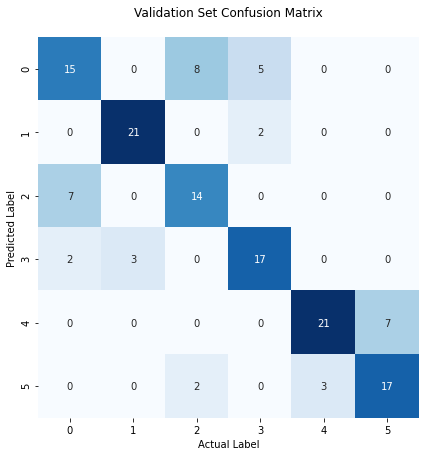

In [ ]:
model_eval(Model_6)

### Model 7

Epoch 1/500
440/440 [==============================] - 9s 16ms/step - loss: 0.0608 - accuracy: 0.9886 - val_loss: 4.1453 - val_accuracy: 0.7300
Epoch 2/500
440/440 [==============================] - 6s 14ms/step - loss: 0.0589 - accuracy: 0.9864 - val_loss: 4.3827 - val_accuracy: 0.7600
Epoch 3/500
440/440 [==============================] - 6s 14ms/step - loss: 0.0793 - accuracy: 0.9886 - val_loss: 4.5327 - val_accuracy: 0.7400
Epoch 4/500
440/440 [==============================] - 6s 13ms/step - loss: 0.1040 - accuracy: 0.9909 - val_loss: 6.5836 - val_accuracy: 0.7300
Epoch 5/500
440/440 [==============================] - 6s 14ms/step - loss: 0.0780 - accuracy: 0.9886 - val_loss: 4.9390 - val_accuracy: 0.7400
Epoch 6/500
440/440 [==============================] - 6s 13ms/step - loss: 0.0156 - accuracy: 0.9977 - val_loss: 6.2496 - val_accuracy: 0.7700
Epoch 7/500
440/440 [==============================] - 6s 14ms/step - loss: 0.0878 - accuracy: 0.9773 - val_loss: 4.9846 - val_accuracy:

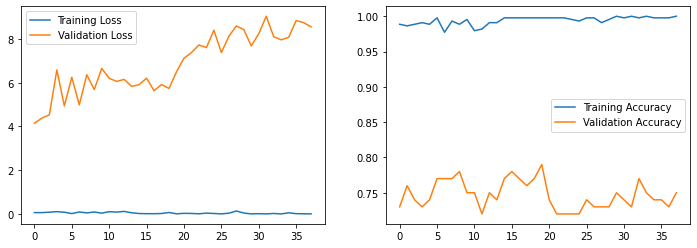

In [ ]:
# RUN MODEL 7

# inputs
k = '7'             # k is the model number
model = model2     # model architectures from above
dropout_rate = 0.4
batchsize = 1

Model_7 = build_model(k, model, batchsize, X_train, y_train, X_test, y_test, X_validate, y_validate)



 Model 7 


Time Elapsed: 232.1  seconds 

Validation Accuracy: 0.7569 

Validation Classification Report:
              precision    recall  f1-score   support

           0     0.6250    0.5556    0.5882        27
           1     0.9167    0.8462    0.8800        26
           2     0.5833    0.7368    0.6512        19
           3     0.7500    0.7826    0.7660        23
           4     0.8750    0.8400    0.8571        25
           5     0.7917    0.7917    0.7917        24

    accuracy                         0.7569       144
   macro avg     0.7569    0.7588    0.7557       144
weighted avg     0.7633    0.7569    0.7582       144



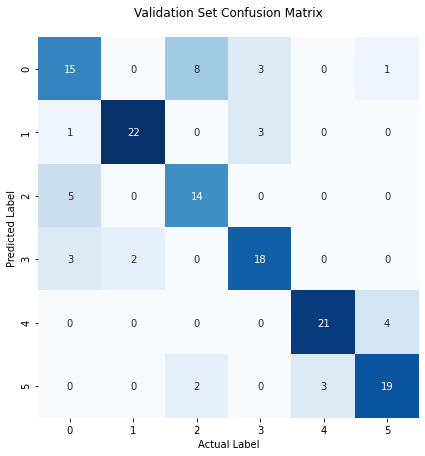

In [ ]:
model_eval(Model_7)

### Model 8

Epoch 1/500
55/55 [==============================] - 4s 40ms/step - loss: 0.0285 - accuracy: 0.9955 - val_loss: 6.2452 - val_accuracy: 0.7500
Epoch 2/500
55/55 [==============================] - 1s 27ms/step - loss: 9.4012e-08 - accuracy: 1.0000 - val_loss: 6.2085 - val_accuracy: 0.7600
Epoch 3/500
55/55 [==============================] - 1s 27ms/step - loss: 8.3685e-07 - accuracy: 1.0000 - val_loss: 6.7026 - val_accuracy: 0.7100
Epoch 4/500
55/55 [==============================] - 1s 27ms/step - loss: 0.0406 - accuracy: 0.9955 - val_loss: 5.9181 - val_accuracy: 0.7500
Epoch 5/500
55/55 [==============================] - 1s 27ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 5.8671 - val_accuracy: 0.7500
Epoch 6/500
55/55 [==============================] - 1s 27ms/step - loss: 2.1247e-06 - accuracy: 1.0000 - val_loss: 5.8587 - val_accuracy: 0.7600
Epoch 7/500
55/55 [==============================] - 1s 27ms/step - loss: 0.0208 - accuracy: 0.9977 - val_loss: 5.7161 - val_accuracy: 0

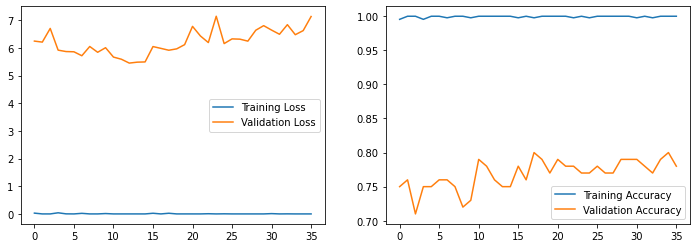

In [ ]:
# RUN MODEL 8

# inputs
k = '8'             # k is the model number
model = model2     # model architectures from above
dropout_rate = 0.4
batchsize = 8

Model_8 = build_model(k, model, batchsize, X_train, y_train, X_test, y_test, X_validate, y_validate)



 Model 8 


Time Elapsed: 56.6  seconds 

Validation Accuracy: 0.7292 

Validation Classification Report:
              precision    recall  f1-score   support

           0     0.5833    0.5000    0.5385        28
           1     0.8750    0.9130    0.8936        23
           2     0.5000    0.6667    0.5714        18
           3     0.7917    0.7308    0.7600        26
           4     0.8750    0.8077    0.8400        26
           5     0.7500    0.7826    0.7660        23

    accuracy                         0.7292       144
   macro avg     0.7292    0.7335    0.7282       144
weighted avg     0.7364    0.7292    0.7301       144



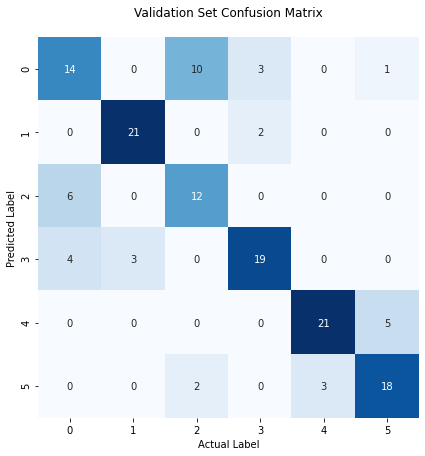

In [ ]:
model_eval(Model_8)

## Compare Models

In [ ]:
compare = pd.DataFrame(columns=['Model Architecture', 'Dropout Rate', 'Batch Size', 'Train Loss', 'Test Loss', 'Validation Loss', 'Train Accuracy', 'Test Accuracy', 'Validation Accuracy'])
compare.loc[Model_1['name']] = pd.Series({'Model Architecture': 'architecture1', 'Dropout Rate': '0.2', 'Batch Size': '1', 'Train Loss': Model_1['train_loss'], 'Test Loss': Model_1['test_loss'], 'Validation Loss': Model_1['validate_loss'], 'Train Accuracy': Model_1['train_accuracy'], 'Test Accuracy': Model_1['test_accuracy'], 'Validation Accuracy': Model_1['validate_accuracy']})
compare.loc[Model_2['name']] = pd.Series({'Model Architecture': 'architecture1', 'Dropout Rate': '0.2', 'Batch Size': '8', 'Train Loss': Model_2['train_loss'], 'Test Loss': Model_2['test_loss'], 'Validation Loss': Model_2['validate_loss'], 'Train Accuracy': Model_2['train_accuracy'], 'Test Accuracy': Model_2['test_accuracy'], 'Validation Accuracy': Model_2['validate_accuracy']})
compare.loc[Model_3['name']] = pd.Series({'Model Architecture': 'architecture1', 'Dropout Rate': '0.4', 'Batch Size': '1', 'Train Loss': Model_3['train_loss'], 'Test Loss': Model_3['test_loss'], 'Validation Loss': Model_3['validate_loss'], 'Train Accuracy': Model_3['train_accuracy'], 'Test Accuracy': Model_3['test_accuracy'], 'Validation Accuracy': Model_3['validate_accuracy']})
compare.loc[Model_4['name']] = pd.Series({'Model Architecture': 'architecture1', 'Dropout Rate': '0.4', 'Batch Size': '8', 'Train Loss': Model_4['train_loss'], 'Test Loss': Model_4['test_loss'], 'Validation Loss': Model_4['validate_loss'], 'Train Accuracy': Model_4['train_accuracy'], 'Test Accuracy': Model_4['test_accuracy'], 'Validation Accuracy': Model_4['validate_accuracy']})
compare.loc[Model_5['name']] = pd.Series({'Model Architecture': 'architecture2', 'Dropout Rate': '0.2', 'Batch Size': '1', 'Train Loss': Model_5['train_loss'], 'Test Loss': Model_5['test_loss'], 'Validation Loss': Model_5['validate_loss'], 'Train Accuracy': Model_5['train_accuracy'], 'Test Accuracy': Model_5['test_accuracy'], 'Validation Accuracy': Model_5['validate_accuracy']})
compare.loc[Model_6['name']] = pd.Series({'Model Architecture': 'architecture2', 'Dropout Rate': '0.2', 'Batch Size': '8', 'Train Loss': Model_6['train_loss'], 'Test Loss': Model_6['test_loss'], 'Validation Loss': Model_6['validate_loss'], 'Train Accuracy': Model_6['train_accuracy'], 'Test Accuracy': Model_6['test_accuracy'], 'Validation Accuracy': Model_6['validate_accuracy']})
compare.loc[Model_7['name']] = pd.Series({'Model Architecture': 'architecture2', 'Dropout Rate': '0.4', 'Batch Size': '1', 'Train Loss': Model_7['train_loss'], 'Test Loss': Model_7['test_loss'], 'Validation Loss': Model_7['validate_loss'], 'Train Accuracy': Model_7['train_accuracy'], 'Test Accuracy': Model_7['test_accuracy'], 'Validation Accuracy': Model_7['validate_accuracy']})
compare.loc[Model_8['name']] = pd.Series({'Model Architecture': 'architecture2', 'Dropout Rate': '0.4', 'Batch Size': '8', 'Train Loss': Model_8['train_loss'], 'Test Loss': Model_8['test_loss'], 'Validation Loss': Model_8['validate_loss'], 'Train Accuracy': Model_8['train_accuracy'], 'Test Accuracy': Model_8['test_accuracy'], 'Validation Accuracy': Model_8['validate_accuracy']})
compare

,Model Architecture,Dropout Rate,Batch Size,Train Loss,Test Loss,Validation Loss,Train Accuracy,Test Accuracy,Validation Accuracy
Model 1,architecture1,0.2,1,0.0176,1.9627,1.8261,0.9932,0.77,0.7500
Model 2,architecture1,0.2,8,0.0000,2.3955,2.2005,1.0000,0.79,0.7500
Model 3,architecture1,0.4,1,0.0000,2.5069,2.5892,1.0000,0.80,0.7500
Model 4,architecture1,0.4,8,0.0000,3.8022,3.1187,1.0000,0.79,0.7292
Model 5,architecture2,0.2,1,0.0343,3.1344,3.0912,0.9909,0.80,0.7292
Model 6,architecture2,0.2,8,0.0064,2.7536,2.9261,0.9977,0.79,0.7292
Model 7,architecture2,0.4,1,0.0000,6.4977,5.3438,1.0000,0.79,0.7569
Model 8,architecture2,0.4,8,0.0000,5.9150,6.4990,1.0000,0.80,0.7292


# Run Final Model

In [ ]:
# model 7 is gonna be my final model

# best parameters: architecture 2, dropout = 0.4, batchsize = 1

In [ ]:
# run final model


# reset 
reset(rs)

# build model structure 
model = tf.keras.Sequential([
  feature_extractor_layer,
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dropout(0.4),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dropout(0.4),
  keras.layers.Dense(6, activation='softmax')
])

# compile the model
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# define callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience = 18, restore_best_weights = True)

# fit the model
history = model.fit(
  X_train, y_train,
  epochs = 500,
  validation_data = (X_test, y_test),
  callbacks = [early_stopping_cb],
  batch_size = 1
)


final_model = model

Epoch 1/500
440/440 [==============================] - 9s 15ms/step - loss: 1.8086 - accuracy: 0.4977 - val_loss: 1.1764 - val_accuracy: 0.6300
Epoch 2/500
440/440 [==============================] - 6s 14ms/step - loss: 1.2179 - accuracy: 0.6659 - val_loss: 1.3156 - val_accuracy: 0.6800
Epoch 3/500
440/440 [==============================] - 6s 15ms/step - loss: 1.1373 - accuracy: 0.6818 - val_loss: 1.5638 - val_accuracy: 0.7300
Epoch 4/500
440/440 [==============================] - 6s 14ms/step - loss: 0.8653 - accuracy: 0.8386 - val_loss: 1.2227 - val_accuracy: 0.7500
Epoch 5/500
440/440 [==============================] - 7s 15ms/step - loss: 0.6184 - accuracy: 0.8341 - val_loss: 1.8406 - val_accuracy: 0.7300
Epoch 6/500
440/440 [==============================] - 6s 14ms/step - loss: 0.7139 - accuracy: 0.8591 - val_loss: 1.9345 - val_accuracy: 0.7400
Epoch 7/500
440/440 [==============================] - 6s 14ms/step - loss: 0.5123 - accuracy: 0.9023 - val_loss: 2.3392 - val_accuracy:

In [ ]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              23853833  
_________________________________________________________________
dense (Dense)                (None, 512)               513024    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 24,433,295
Trainable params: 579,462
Non-trainable params: 23,853,833
______________________________________

In [ ]:
# Evaluate the final model on the validation set

print("Evaluate the final model on the validation set:")
results = final_model.evaluate(X_validate, y_validate, batch_size=1)
print("Test Loss, Test Accuracy:", results)

Evaluate the final model on the validation set:
144/144 [==============================] - 2s 12ms/step - loss: 3.4041 - accuracy: 0.7569
Test Loss, Test Accuracy: [3.40411376953125, 0.7569444179534912]


# # Save Final Model as TF Lite Model

In [ ]:
# Create a converter
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)

# Convert the model
tflite_model = converter.convert()

# Create the tflite model file
tflite_model_name = "family_classification_model.tflite"
open(tflite_model_name, "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp07grdrcr/assets


INFO:tensorflow:Assets written to: /tmp/tmp07grdrcr/assets


97812172